# EO-Forge Loaders 1.0.3

## EO-Forge Loaders

__NOTE__: EO-Forge Loaders are meant to be used on a "local" archiving scheme (your laptop storage, a NFS storage,etc) not (__yet__) on Cloud Buckets, but more on this latter!

We will cover the basics steps to load an scene (and crop some roi-_region of interest_- on it) of:

- Sentinel 2 - processing level: __L2A__ (on-duty)
- Sentinel 2 - processing level: __L1C__ (on-duty)

at two differents times. Since 20220125 L1C and L2A have changed the Masks. GML files were deprecated in favor of Rasters Masks.
They also added some offsets regarding bands calibrations for reflectance.

We will be using:

- S2A_MSIL1C_20210810T141741_N0301_R010_T19FCF_20210810T193059.SAFE (<20220125)
- S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924.SAFE (<20220125)
- S2B_MSIL1C_20220201T141729_N0400_R010_T19FCF_20220201T171833.SAFE (>20220125)
- S2B_MSIL2A_20220201T141729_N0400_R010_T19FCF_20220201T180813.SAFE (>20220125)


### Images

We assume that you have already downloaded some images (you could use _sentinelsat_ for instance).

We are insterested on Tile __19FCF__ (just to continue with the same images from previous examples).

You can download this with the sentinelsat library using:

```python
from sentinelsat import SentinelAPI
api = SentinelAPI('user', 'password', 'https://apihub.copernicus.eu/apihub')

# api.download(<product_id>)
api.download("eb2b9bc6-bbb4-4d89-bab7-f9508cb877d2") # L2A 2021
api.download("2a43f92c-545f-43ec-9ac5-317fb0d818eb") # L1C 2022
api.download("c35d5efb-a0dc-4ac6-9a20-604c8d9d191e")  # L1C 2022
```

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rasterio as rio
import geopandas as gpd

from earthpy import plot

In [2]:
from eo_forge.io.SentinelLoaders import Sentinel2Loader

In [3]:
# Base dir
TMP_PROD = "./products-int/"
# IMAGES RAW Search Path
IMAGES_RAW = os.path.join(TMP_PROD, "images-raw")

# IMAGES CROP Path (to leave cropped files - if apply)
PROD_INT_DIR = os.path.join(TMP_PROD, "images-crop")
os.makedirs(PROD_INT_DIR, exist_ok=True)

## Sentinel2  Image

In [4]:
# Init Loader and query bands
SENTINEL2_BANDS = ["B02", "B03", "B04", "B08", "B11"]
lp = Sentinel2Loader(
    IMAGES_RAW, bands=SENTINEL2_BANDS, resolution=10, level="l2a"
)
# L1C
lp_l1c = Sentinel2Loader(
    IMAGES_RAW, bands=SENTINEL2_BANDS, resolution=10, level="l1c"
)

2022/02/09 11:36:51 - INFO - Running on Sentinel 2 - l2a data
2022/02/09 11:36:51 - INFO - Running on Sentinel 2 - l1c data


## BBox - Levels L2A and L1C  < 20220125

We compare the levels L2A and L1C from the same image (on a reduced BBox).

In [5]:
# now use bbox
bbox = gpd.read_file("./data/cardiel-lake.geojson")
# and do not write anything
product_id = "S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924.SAFE"

res_bbox = lp.execute(
    product_id,
    bbox=bbox,
    folder_proc_=PROD_INT_DIR,
    raster_return_open=True,
    write_file=None,
    clouds_legacy=True,
)

print("########### L1C ##############")

#
product_id_l1c = "S2A_MSIL1C_20210810T141741_N0301_R010_T19FCF_20210810T193059.SAFE"
res_bbox_l1c = lp_l1c.execute(
    product_id_l1c,
    bbox=bbox,
    folder_proc_=PROD_INT_DIR,
    raster_return_open=True,
    write_file=None,
    clouds_legacy=True,
)

2022/02/09 11:36:51 - INFO - Processing on ./products-int/images-raw/S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924.SAFE dir
2022/02/09 11:36:51 - INFO - Using clipping flag: True
2022/02/09 11:36:51 - INFO - PROCESSING band: B02
2022/02/09 11:36:51 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/02/09 11:36:51 - INFO - checking  ROI
2022/02/09 11:36:51 - INFO - checking roi match - full match: True - area: 1
2022/02/09 11:36:51 - INFO - clipping with Tight BBox
2022/02/09 11:36:52 - INFO - calibrating band
2022/02/09 11:36:52 - INFO - reprojecting band
2022/02/09 11:36:52 - INFO - PROCESSING band: B03
2022/02/09 11:36:52 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/02/09 11:36:52 - INFO - checking  ROI
2022/02/09 11:36:52 - INFO - checking roi match - full match: True - area: 1
2022/02/09 11:36:52 - INFO - clipping with Tight BBox
2022/02/09 11:36:53 - INFO - calibrating band
2022/02/09 11:36:53 - INFO - reprojecting band
2022/02/09 1

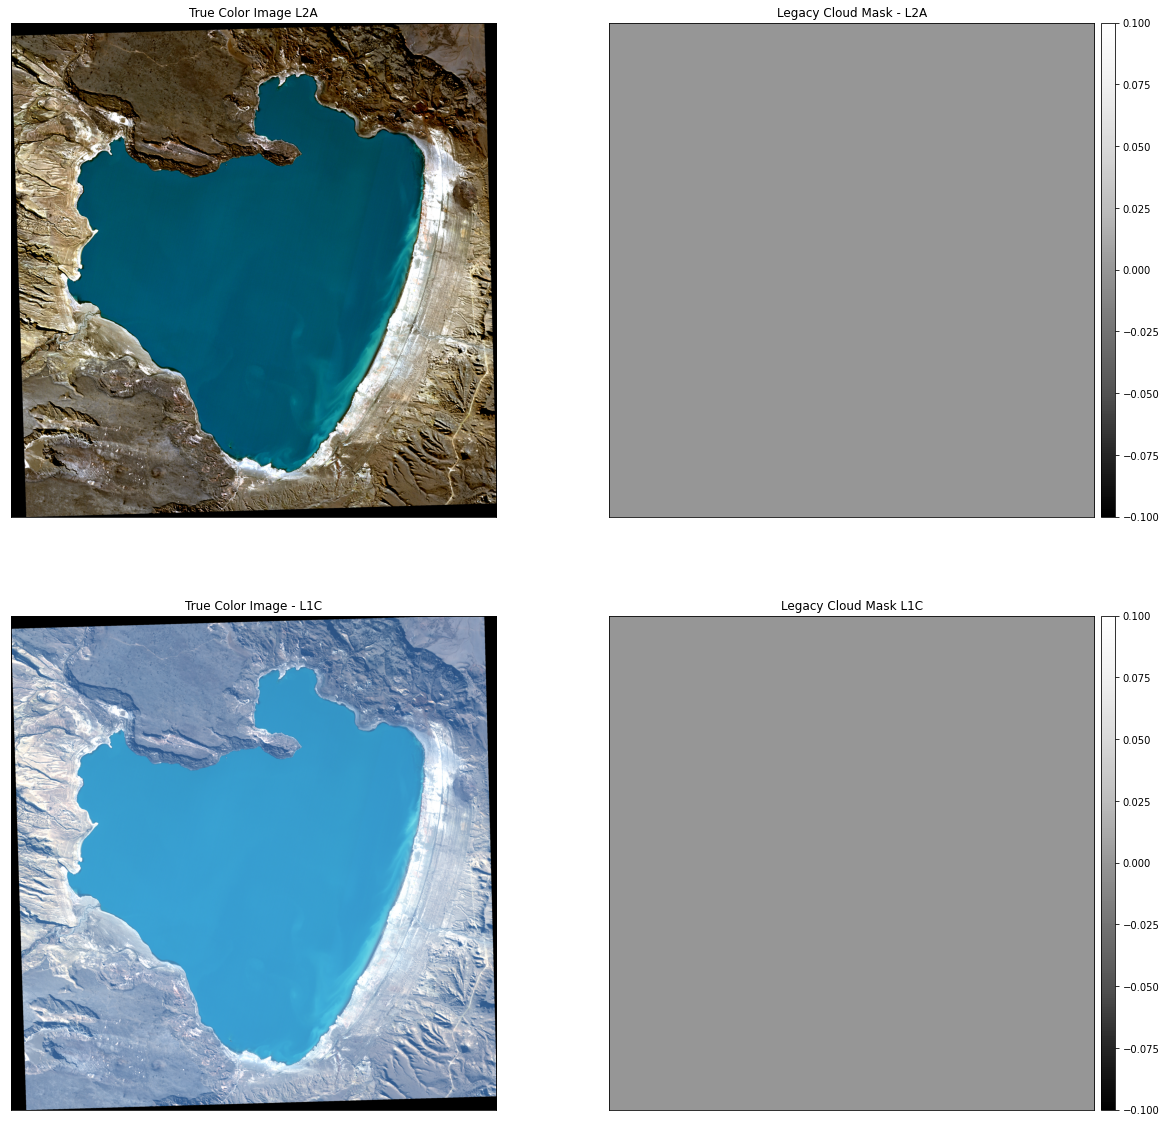

In [6]:
f, ax = plt.subplots(2, 2, figsize=(20, 20))
raster = res_bbox["raster"]
plot.plot_rgb(raster.read(), rgb=(2, 1, 0), ax=ax[0][0], stretch=True)
ax[0][0].set_title("True Color Image L2A")

raster = res_bbox["raster_cloud"]
plot.plot_bands(raster.read(), ax=ax[0][1])
ax[0][1].set_title("Legacy Cloud Mask - L2A")


raster = res_bbox_l1c["raster"]
plot.plot_rgb(raster.read(), rgb=(2, 1, 0), ax=ax[1][0], stretch=True)
ax[1][0].set_title("True Color Image - L1C")

raster = res_bbox_l1c["raster_cloud"]
plot.plot_bands(raster.read(), ax=ax[1][1])
ax[1][1].set_title("Legacy Cloud Mask L1C");

Check the metadata from both cases Bands offset should be 0

In [7]:
from eo_forge.utils.sentinel import s2_metadata

In [8]:
s2_meta=s2_metadata()

In [9]:
s2_meta.read_metadata_l2a('./products-int/images-raw/S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924.SAFE/')

{'NODATA': 0,
 'SATURATED': 65535,
 'quantification_value': 10000,
 'band_files': {'B02': './products-int/images-raw/S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924.SAFE//GRANULE/L2A_T19FCF_A032039_20210810T143443/IMG_DATA/R10m/T19FCF_20210810T141741_B02_10m.jp2',
  'B03': './products-int/images-raw/S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924.SAFE//GRANULE/L2A_T19FCF_A032039_20210810T143443/IMG_DATA/R10m/T19FCF_20210810T141741_B03_10m.jp2',
  'B04': './products-int/images-raw/S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924.SAFE//GRANULE/L2A_T19FCF_A032039_20210810T143443/IMG_DATA/R10m/T19FCF_20210810T141741_B04_10m.jp2',
  'B08': './products-int/images-raw/S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924.SAFE//GRANULE/L2A_T19FCF_A032039_20210810T143443/IMG_DATA/R10m/T19FCF_20210810T141741_B08_10m.jp2',
  'TCI': './products-int/images-raw/S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924.SAFE//GRANULE/L2A_T19FCF_A032039_2

In [10]:
s2_meta.read_metadata_l1c('./products-int/images-raw/S2A_MSIL1C_20210810T141741_N0301_R010_T19FCF_20210810T193059.SAFE/')

{'NODATA': 0,
 'SATURATED': 65535,
 'quantification_value': 10000,
 'band_files': {'B01': './products-int/images-raw/S2A_MSIL1C_20210810T141741_N0301_R010_T19FCF_20210810T193059.SAFE/GRANULE/L1C_T19FCF_A032039_20210810T143443/IMG_DATA/T19FCF_20210810T141741_B01.jp2',
  'B02': './products-int/images-raw/S2A_MSIL1C_20210810T141741_N0301_R010_T19FCF_20210810T193059.SAFE/GRANULE/L1C_T19FCF_A032039_20210810T143443/IMG_DATA/T19FCF_20210810T141741_B02.jp2',
  'B03': './products-int/images-raw/S2A_MSIL1C_20210810T141741_N0301_R010_T19FCF_20210810T193059.SAFE/GRANULE/L1C_T19FCF_A032039_20210810T143443/IMG_DATA/T19FCF_20210810T141741_B03.jp2',
  'B04': './products-int/images-raw/S2A_MSIL1C_20210810T141741_N0301_R010_T19FCF_20210810T193059.SAFE/GRANULE/L1C_T19FCF_A032039_20210810T143443/IMG_DATA/T19FCF_20210810T141741_B04.jp2',
  'B05': './products-int/images-raw/S2A_MSIL1C_20210810T141741_N0301_R010_T19FCF_20210810T193059.SAFE/GRANULE/L1C_T19FCF_A032039_20210810T143443/IMG_DATA/T19FCF_20210810T1

Now try new date

In [11]:
# now use bbox
bbox = gpd.read_file("./data/cardiel-lake.geojson")
# and do not write anything
product_id = "S2B_MSIL2A_20220201T141729_N0400_R010_T19FCF_20220201T180813.SAFE"

res_bbox = lp.execute(
    product_id,
    bbox=bbox,
    folder_proc_=PROD_INT_DIR,
    raster_return_open=True,
    write_file=None,
    clouds_legacy=True,
)

print("########### L1C ##############")

#
product_id_l1c = "S2B_MSIL1C_20220201T141729_N0400_R010_T19FCF_20220201T171833.SAFE"
res_bbox_l1c = lp_l1c.execute(
    product_id_l1c,
    bbox=bbox,
    folder_proc_=PROD_INT_DIR,
    raster_return_open=True,
    write_file=None,
    clouds_legacy=True,
)

2022/02/09 11:37:22 - INFO - Processing on ./products-int/images-raw/S2B_MSIL2A_20220201T141729_N0400_R010_T19FCF_20220201T180813.SAFE dir
2022/02/09 11:37:23 - INFO - Using clipping flag: True
2022/02/09 11:37:23 - INFO - PROCESSING band: B02
2022/02/09 11:37:23 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/02/09 11:37:23 - INFO - checking  ROI
2022/02/09 11:37:23 - INFO - checking roi match - full match: True - area: 1
2022/02/09 11:37:23 - INFO - clipping with Tight BBox
2022/02/09 11:37:23 - INFO - calibrating band
2022/02/09 11:37:24 - INFO - reprojecting band
2022/02/09 11:37:24 - INFO - PROCESSING band: B03
2022/02/09 11:37:24 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/02/09 11:37:24 - INFO - checking  ROI
2022/02/09 11:37:24 - INFO - checking roi match - full match: True - area: 1
2022/02/09 11:37:24 - INFO - clipping with Tight BBox
2022/02/09 11:37:24 - INFO - calibrating band
2022/02/09 11:37:25 - INFO - reprojecting band
2022/02/09 1

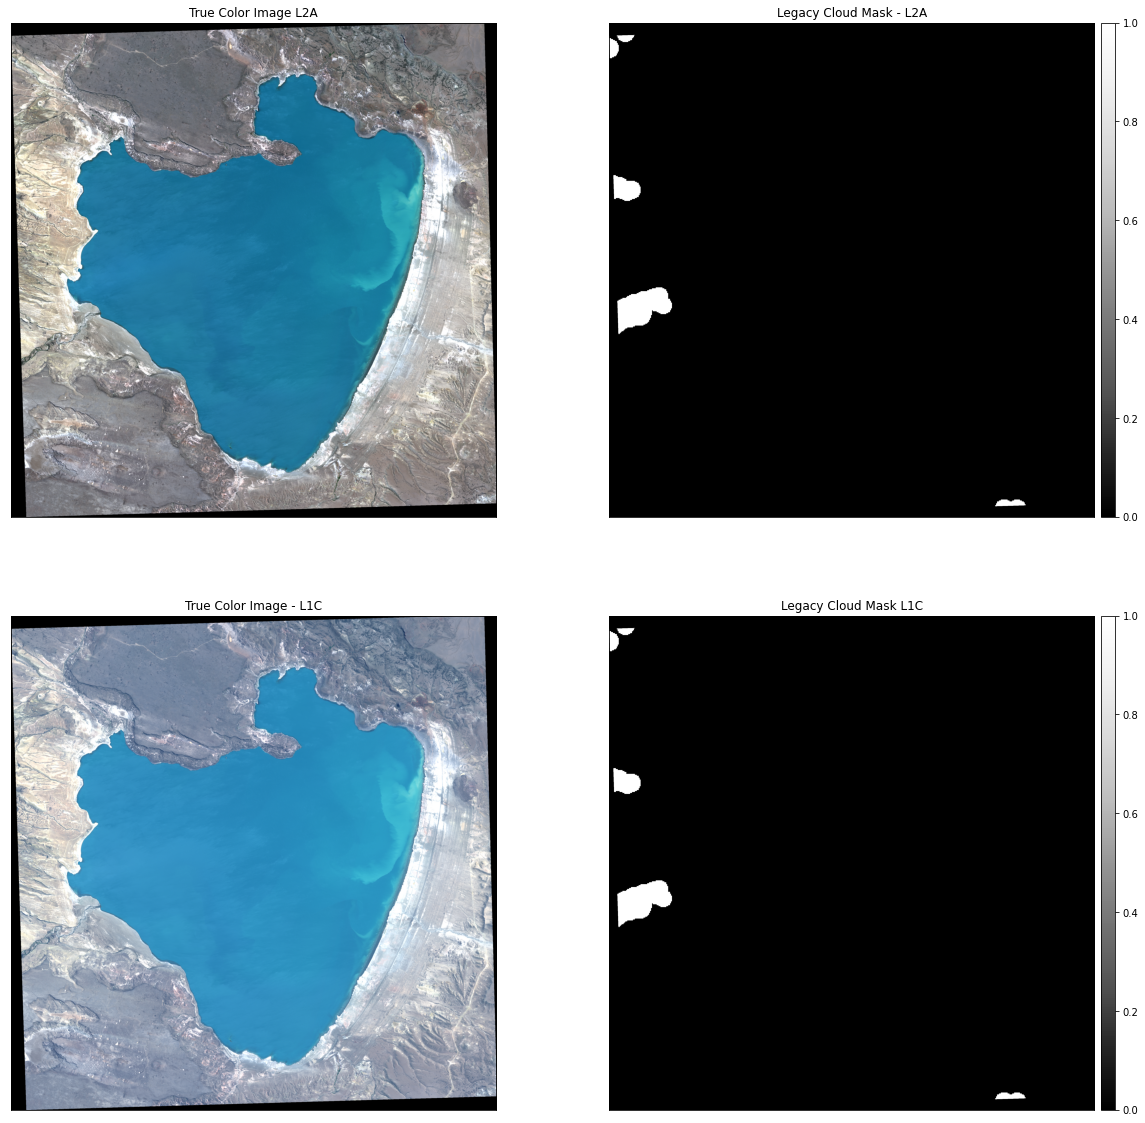

In [12]:
f, ax = plt.subplots(2, 2, figsize=(20, 20))
raster = res_bbox["raster"]
plot.plot_rgb(raster.read(), rgb=(2, 1, 0), ax=ax[0][0], stretch=True)
ax[0][0].set_title("True Color Image L2A")

raster = res_bbox["raster_cloud"]
plot.plot_bands(raster.read(), ax=ax[0][1])
ax[0][1].set_title("Legacy Cloud Mask - L2A")


raster = res_bbox_l1c["raster"]
plot.plot_rgb(raster.read(), rgb=(2, 1, 0), ax=ax[1][0], stretch=True)
ax[1][0].set_title("True Color Image - L1C")

raster = res_bbox_l1c["raster_cloud"]
plot.plot_bands(raster.read(), ax=ax[1][1])
ax[1][1].set_title("Legacy Cloud Mask L1C");

In [13]:
s2_meta.read_metadata_l2a('./products-int/images-raw/S2B_MSIL2A_20220201T141729_N0400_R010_T19FCF_20220201T180813.SAFE/')

{'NODATA': 0,
 'SATURATED': 65535,
 'quantification_value': 10000,
 'band_files': {'B02': './products-int/images-raw/S2B_MSIL2A_20220201T141729_N0400_R010_T19FCF_20220201T180813.SAFE//GRANULE/L2A_T19FCF_A025633_20220201T142713/IMG_DATA/R10m/T19FCF_20220201T141729_B02_10m.jp2',
  'B03': './products-int/images-raw/S2B_MSIL2A_20220201T141729_N0400_R010_T19FCF_20220201T180813.SAFE//GRANULE/L2A_T19FCF_A025633_20220201T142713/IMG_DATA/R10m/T19FCF_20220201T141729_B03_10m.jp2',
  'B04': './products-int/images-raw/S2B_MSIL2A_20220201T141729_N0400_R010_T19FCF_20220201T180813.SAFE//GRANULE/L2A_T19FCF_A025633_20220201T142713/IMG_DATA/R10m/T19FCF_20220201T141729_B04_10m.jp2',
  'B08': './products-int/images-raw/S2B_MSIL2A_20220201T141729_N0400_R010_T19FCF_20220201T180813.SAFE//GRANULE/L2A_T19FCF_A025633_20220201T142713/IMG_DATA/R10m/T19FCF_20220201T141729_B08_10m.jp2',
  'TCI': './products-int/images-raw/S2B_MSIL2A_20220201T141729_N0400_R010_T19FCF_20220201T180813.SAFE//GRANULE/L2A_T19FCF_A025633_2

In [14]:
s2_meta.read_metadata_l1c('./products-int/images-raw/S2B_MSIL1C_20220201T141729_N0400_R010_T19FCF_20220201T171833.SAFE/')

{'NODATA': 0,
 'SATURATED': 65535,
 'quantification_value': 10000,
 'band_files': {'B01': './products-int/images-raw/S2B_MSIL1C_20220201T141729_N0400_R010_T19FCF_20220201T171833.SAFE/GRANULE/L1C_T19FCF_A025633_20220201T142713/IMG_DATA/T19FCF_20220201T141729_B01.jp2',
  'B02': './products-int/images-raw/S2B_MSIL1C_20220201T141729_N0400_R010_T19FCF_20220201T171833.SAFE/GRANULE/L1C_T19FCF_A025633_20220201T142713/IMG_DATA/T19FCF_20220201T141729_B02.jp2',
  'B03': './products-int/images-raw/S2B_MSIL1C_20220201T141729_N0400_R010_T19FCF_20220201T171833.SAFE/GRANULE/L1C_T19FCF_A025633_20220201T142713/IMG_DATA/T19FCF_20220201T141729_B03.jp2',
  'B04': './products-int/images-raw/S2B_MSIL1C_20220201T141729_N0400_R010_T19FCF_20220201T171833.SAFE/GRANULE/L1C_T19FCF_A025633_20220201T142713/IMG_DATA/T19FCF_20220201T141729_B04.jp2',
  'B05': './products-int/images-raw/S2B_MSIL1C_20220201T141729_N0400_R010_T19FCF_20220201T171833.SAFE/GRANULE/L1C_T19FCF_A025633_20220201T142713/IMG_DATA/T19FCF_20220201T1

Now force cloud legacy to False in the new dates

In [15]:
# now use bbox
bbox = gpd.read_file("./data/cardiel-lake.geojson")
# and do not write anything
product_id = "S2B_MSIL2A_20220201T141729_N0400_R010_T19FCF_20220201T180813.SAFE"

res_bbox = lp.execute(
    product_id,
    bbox=bbox,
    folder_proc_=PROD_INT_DIR,
    raster_return_open=True,
    write_file=None,
    clouds_legacy=False,
)

print("########### L1C ##############")

#
product_id_l1c = "S2B_MSIL1C_20220201T141729_N0400_R010_T19FCF_20220201T171833.SAFE"
res_bbox_l1c = lp_l1c.execute(
    product_id_l1c,
    bbox=bbox,
    folder_proc_=PROD_INT_DIR,
    raster_return_open=True,
    write_file=None,
    clouds_legacy=False,
)

2022/02/09 11:37:51 - INFO - Processing on ./products-int/images-raw/S2B_MSIL2A_20220201T141729_N0400_R010_T19FCF_20220201T180813.SAFE dir
2022/02/09 11:37:51 - INFO - Using clipping flag: True
2022/02/09 11:37:51 - INFO - PROCESSING band: B02
2022/02/09 11:37:51 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/02/09 11:37:51 - INFO - checking  ROI
2022/02/09 11:37:51 - INFO - checking roi match - full match: True - area: 1
2022/02/09 11:37:51 - INFO - clipping with Tight BBox
2022/02/09 11:37:51 - INFO - calibrating band
2022/02/09 11:37:52 - INFO - reprojecting band
2022/02/09 11:37:52 - INFO - PROCESSING band: B03
2022/02/09 11:37:52 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/02/09 11:37:52 - INFO - checking  ROI
2022/02/09 11:37:52 - INFO - checking roi match - full match: True - area: 1
2022/02/09 11:37:52 - INFO - clipping with Tight BBox
2022/02/09 11:37:52 - INFO - calibrating band
2022/02/09 11:37:53 - INFO - reprojecting band
2022/02/09 1

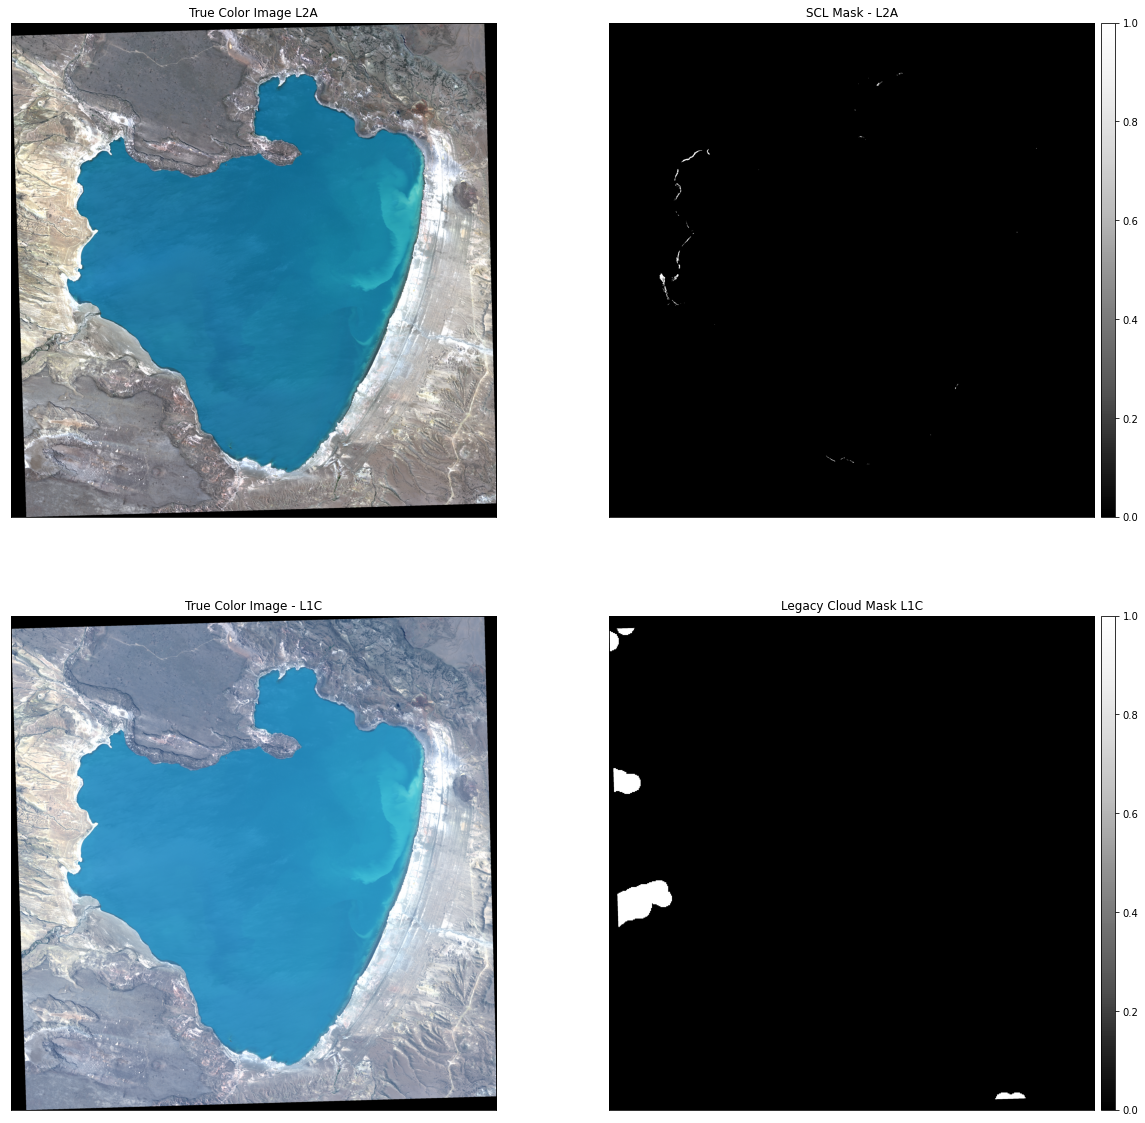

In [16]:
f, ax = plt.subplots(2, 2, figsize=(20, 20))
raster = res_bbox["raster"]
plot.plot_rgb(raster.read(), rgb=(2, 1, 0), ax=ax[0][0], stretch=True)
ax[0][0].set_title("True Color Image L2A")

raster = res_bbox["raster_cloud"]
plot.plot_bands(raster.read(), ax=ax[0][1])
ax[0][1].set_title("SCL Mask - L2A")


raster = res_bbox_l1c["raster"]
plot.plot_rgb(raster.read(), rgb=(2, 1, 0), ax=ax[1][0], stretch=True)
ax[1][0].set_title("True Color Image - L1C")

raster = res_bbox_l1c["raster_cloud"]
plot.plot_bands(raster.read(), ax=ax[1][1])
ax[1][1].set_title("Legacy Cloud Mask L1C");